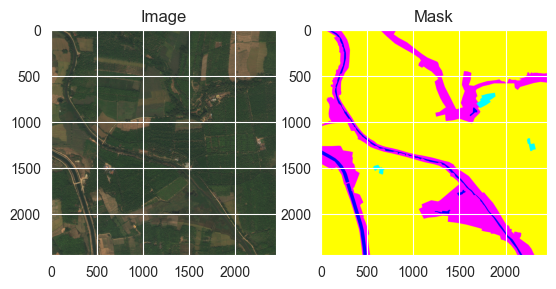

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

# Шлях до папки з зображеннями та масками
data_folder = r"D:\Andrii\diferent\dataset\DeepGlobe Land Cover Classification Dataset\train"

# Завантаження номерів класів та їх назв з CSV файлу
class_dict_path = r"D:\Andrii\diferent\dataset\DeepGlobe Land Cover Classification Dataset\class_dict.csv"
#class_dict = pd.read_csv(class_dict_path, index_col='code')

def display_image_and_mask(image_path, mask_path):
    # Відображення зображення
    image = Image.open(image_path)
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title('Image')

    # Відображення маски
    mask = Image.open(mask_path)
    plt.subplot(1, 2, 2)
    plt.imshow(mask)
    plt.title('Mask')

    plt.show()

# Введення номеру картинки
image_number = 119

# Створення шляхів до зображення та маски за номером картинки
image_path = os.path.join(data_folder, f"{image_number}_sat.jpg")
mask_path = os.path.join(data_folder, f"{image_number}_mask.png")

# Перевірка існування файлів
if os.path.exists(image_path) and os.path.exists(mask_path):
    # Вивід картинок в більшій роздільній якості
    display_image_and_mask(image_path, mask_path)
else:
    print("Зображення або маска для введеного номеру не знайдені.")

In [2]:
import os, cv2
import numpy as np
import pandas as pd
import random, tqdm
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import random
import warnings
warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import albumentations as album



In [3]:
#!pip install -q -U segmentation-models-pytorch albumentations > /dev/null
import segmentation_models_pytorch as smp

In [4]:
#data_root = r"D:\\Andrii\\diferent\\dataset\\DeepGlobe Land Cover Classification Dataset\\train"
DATA_DIR = r"D:\\Andrii\\diferent\\dataset\\DeepGlobe Land Cover Classification Dataset"
metadata_df = pd.read_csv(os.path.join(DATA_DIR, 'metadata.csv'))
metadata_df = metadata_df[metadata_df['split']=='train']
metadata_df = metadata_df[['image_id', 'sat_image_path', 'mask_path']]
metadata_df['sat_image_path'] = metadata_df['sat_image_path'].apply(lambda img_pth: os.path.join(DATA_DIR, img_pth))
metadata_df['mask_path'] = metadata_df['mask_path'].apply(lambda img_pth: os.path.join(DATA_DIR, img_pth))
# Shuffle DataFrame
metadata_df = metadata_df.sample(frac=1).reset_index(drop=True)

# Perform 90/10 split for train / val
valid_df = metadata_df.sample(frac=0.1, random_state=42)
train_df = metadata_df.drop(valid_df.index)
len(train_df), len(valid_df)

(723, 80)

In [5]:
class_dict = pd.read_csv(os.path.join(DATA_DIR, 'class_dict.csv'))
# Get class names
class_names = class_dict['name'].tolist()
# Get class RGB values
class_rgb_values = class_dict[['r','g','b']].values.tolist()

print('All dataset classes and their corresponding RGB values in labels:')
print('Class Names: ', class_names)
print('Class RGB values: ', class_rgb_values)

All dataset classes and their corresponding RGB values in labels:
Class Names:  ['urban_land', 'agriculture_land', 'rangeland', 'forest_land', 'water', 'barren_land', 'unknown']
Class RGB values:  [[0, 255, 255], [255, 255, 0], [255, 0, 255], [0, 255, 0], [0, 0, 255], [255, 255, 255], [0, 0, 0]]


In [6]:
# Useful to shortlist specific classes in datasets with large number of classes
select_classes = ['urban_land', 'agriculture_land', 'rangeland', 'forest_land', 'water', 'barren_land', 'unknown']

# Get RGB values of required classes
select_class_indices = [class_names.index(cls.lower()) for cls in select_classes]
select_class_rgb_values =  np.array(class_rgb_values)[select_class_indices]

print('Selected classes and their corresponding RGB values in labels:')
print('Class Names: ', class_names)
print('Class RGB values: ', class_rgb_values)

Selected classes and their corresponding RGB values in labels:
Class Names:  ['urban_land', 'agriculture_land', 'rangeland', 'forest_land', 'water', 'barren_land', 'unknown']
Class RGB values:  [[0, 255, 255], [255, 255, 0], [255, 0, 255], [0, 255, 0], [0, 0, 255], [255, 255, 255], [0, 0, 0]]


In [10]:
import torch
import torch.nn as nn
from torchvision import transforms, datasets
from PIL import Image
import pandas as pd
import numpy as np
df=pd.read_csv(r"D:\Andrii\diferent\dataset\DeepGlobe Land Cover Classification Dataset\metadata.csv")
df=df[df['split']=='train']
df['filepath']=df['sat_image_path'].apply(lambda x: 'D:\Andrii\diferent\dataset\DeepGlobe Land Cover Classification Dataset/'+x)
filepaths=np.array(df['filepath'])
df.head()

,image_id,split,sat_image_path,mask_path,filepath
0,100694,train,train/100694_sat.jpg,train/100694_mask.png,D:\Andrii\diferent\dataset\DeepGlobe Land Cove...
1,102122,train,train/102122_sat.jpg,train/102122_mask.png,D:\Andrii\diferent\dataset\DeepGlobe Land Cove...
2,10233,train,train/10233_sat.jpg,train/10233_mask.png,D:\Andrii\diferent\dataset\DeepGlobe Land Cove...
3,103665,train,train/103665_sat.jpg,train/103665_mask.png,D:\Andrii\diferent\dataset\DeepGlobe Land Cove...
4,103730,train,train/103730_sat.jpg,train/103730_mask.png,D:\Andrii\diferent\dataset\DeepGlobe Land Cove...


In [11]:
import torch.nn as nn
from torchvision import transforms, datasets
transform = transforms.Compose([transforms.Resize((256,256)),transforms.ToTensor()])
class ImageDataset(torch.utils.data.Dataset):
    def __init__(self, img_paths, transform=None):
        self.img_paths = img_paths
        self.transform = transform

    def __getitem__(self, index):
        path = self.img_paths[index]
        img = Image.open(path).convert('RGB')
        if self.transform is not None:
            img = self.transform(img)
        return img

    def __len__(self):
        return len(self.img_paths)

dataset=ImageDataset(filepaths,transform)
# Define the dataloader to load the dataset
dataloader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=False)

In [12]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 8, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(8, 4, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(4, 8, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(8, 16, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, kernel_size=3, stride=2, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Define the autoencoder model
autoencoder = Autoencoder()

In [13]:
features = []
with torch.no_grad():
    for data in dataloader:
        img = data
#         img = img.cuda()
        feature = autoencoder.encoder(img)
        feature = feature.view(feature.size(0), -1)
        features.append(feature)

In [14]:
concat_feat = torch.cat(features, dim=0)

In [15]:
df['features']=-1
for i in range(len(concat_feat)):
    df['features'][i]=str((concat_feat[i].tolist()))

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 803 entries, 0 to 802
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   image_id        803 non-null    int64 
 1   split           803 non-null    object
 2   sat_image_path  803 non-null    object
 3   mask_path       803 non-null    object
 4   filepath        803 non-null    object
 5   features        803 non-null    object
dtypes: int64(1), object(5)
memory usage: 76.2+ KB


In [17]:
df.head()

,image_id,split,sat_image_path,mask_path,filepath,features
0,100694,train,train/100694_sat.jpg,train/100694_mask.png,D:\Andrii\diferent\dataset\DeepGlobe Land Cove...,"[0.0, 0.0027048327028751373, 0.010169837623834..."
1,102122,train,train/102122_sat.jpg,train/102122_mask.png,D:\Andrii\diferent\dataset\DeepGlobe Land Cove...,"[0.0, 0.005133282393217087, 0.0114618949592113..."
2,10233,train,train/10233_sat.jpg,train/10233_mask.png,D:\Andrii\diferent\dataset\DeepGlobe Land Cove...,"[0.0, 0.002590365707874298, 0.0005204156041145..."
3,103665,train,train/103665_sat.jpg,train/103665_mask.png,D:\Andrii\diferent\dataset\DeepGlobe Land Cove...,"[0.0, 0.011458855122327805, 0.0111072398722171..."
4,103730,train,train/103730_sat.jpg,train/103730_mask.png,D:\Andrii\diferent\dataset\DeepGlobe Land Cove...,"[0.0, 0.010804746299982071, 0.0159998275339603..."


In [20]:
import ast

x=ast.literal_eval(df['features'][0])

In [21]:
df.to_csv('metadata.csv',index=False)

In [22]:
512*512*3--4096

790528